In [1]:
%matplotlib inline

# DEFAULTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson
import sys
sys.path.append("..")
from truncation import get_truncation


FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

# plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

# plt.rc('text', usetex=False)
plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

exp_style = [
    {"fmt": "ok"},
    {"fmt": "ok", "markerfacecolor": "None", "markeredgecolor": "k"},
    {"fmt": "sk"},
    {"fmt": "^k"},
    {"fmt": "Xk"},
    {"fmt": "dk"},
]

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


df_my = pd.read_csv("./deuteron_all_data.csv")
df_my.T21D2 *= 2
df_my.T22D2 *= 2
df_my.T21D *= 2
df_my.T22D *= 2
df_my.AX *= -1
df_my.AX2 *= -1

df_neuteron = pd.read_csv("./neuteron_Detected_data_2p75mev.csv")
df_neuteron100 = pd.read_csv("./neuteron_Detected_data_100mev.csv")
df_neuteron.T21D2 *= 2
df_neuteron.T22D2 *= 2
df_neuteron.T21D *= 2
df_neuteron.T22D *= 2
df_neuteron.AX *= -1
df_neuteron.AX2 *= -1
df_neuteron100.T21D2 *= 2
df_neuteron100.T22D2 *= 2
df_neuteron100.T21D *= 2
df_neuteron100.T22D *= 2
df_neuteron100.AX *= -1
df_neuteron100.AX2 *= -1

OBSERVABLES = [ob for ob in df_my.columns.values if ob not in [
    "THCM", "angle", "CUTOFF", "FORCE"]]

my_energies = df_my.Energy.unique()
my_energies.sort()

In [16]:
def relative_diff(*args):
    return np.abs((max(args) - min(args))/np.mean(args))

# Neuteron Polarization

In [3]:
df_jewell = pd.read_csv("./ExpData/PolarizationNeuteron/Jewell1965.dat")
df_cameron = pd.read_csv("./ExpData/PolarizationNeuteron/Cameron1986.dat")

/tmp/ipykernel_386620/2453384594.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is depreca

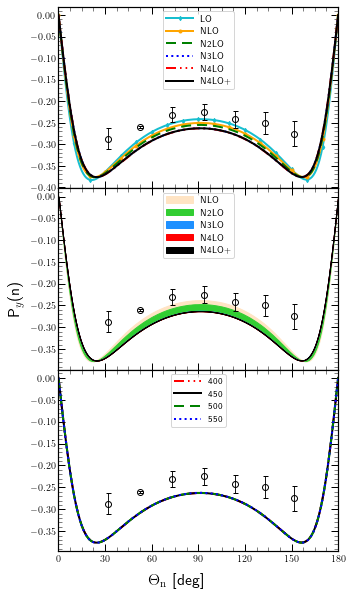

In [6]:
obs = "POLNOUT2(y)"
energy=2.75
cutoff=450
df=df_neuteron
wave="SIEGERT"
ylabel="P$_y$(n)"
df_tmp = df[(df.CUTOFF == cutoff) &
            (df.WAVE == wave)]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy)

fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3, hspace=0)
axes = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{n}$ [deg]", y=0.02, size=16)
if not ylabel:
    ylabel = obs
fig.supylabel(ylabel, x=0.03, size=16)
for force in FORCES:
    df_tmp = df[(df.FORCE == force) &
                (df.CUTOFF == cutoff) &
                # (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                **line_styles[force], label=force)
    if force != "LO":
        axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                            df_tmp[obs].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
    # break
for cut in CUTOFF:
    df_tmp = df[(df.FORCE == "N4LO+") &
                (df.CUTOFF == cut) &
                # (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    # print(df_tmp.head())
    axes[2].plot(df_tmp.angle, df_tmp[obs],
                **ls_cutoff[cut], label=cut)
# df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
for j, ax in enumerate(axes):
    ax.errorbar(df_jewell.Theta, df_jewell["P(n)"],
                yerr=df_jewell.Error, zorder=3, **exp_style[1], **marker_common)
                    # , label=df_tmp.fname[0])
    # if j != 1:
    #     ax.plot(df_av18.angle, df_av18[obs],
    #             **line_styles["AV18"], label="AV18")

    ax.legend(fontsize=9, handlelength=3, loc="upper center")
    
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    # ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
plt.savefig(f"../Figures_De/{obs}_{energy}mev_neuteron.pdf",
            dpi=600, facecolor="white")

In [7]:
df_neuteron100.FORCE.unique()

array(['N4LO+', 'NLO', 'N3LO', 'N2LO', 'N4LO', 'LO'], dtype=object)

/tmp/ipykernel_386620/3547819425.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is depreca

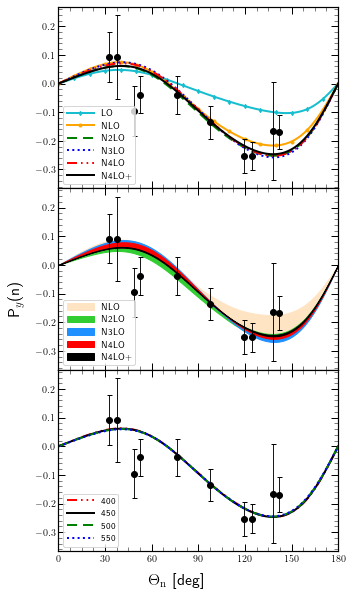

In [8]:
obs = "POLNOUT2(y)"
energy=100
cutoff=450
df=df_neuteron100
wave="SIEGERT"
ylabel="P$_y$(n)"
df_tmp = df[(df.CUTOFF == cutoff) &
            (df.WAVE == wave)]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy)

fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3, hspace=0)
axes = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{n}$ [deg]", y=0.02, size=16)
if not ylabel:
    ylabel = obs
fig.supylabel(ylabel, x=0.03, size=16)
for force in FORCES:
    df_tmp = df[(df.FORCE == force) &
                (df.CUTOFF == cutoff) &
                # (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                **line_styles[force], label=force)
    if force != "LO":
        axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                            df_tmp[obs].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
    # break
for cut in CUTOFF:
    df_tmp = df[(df.FORCE == "N4LO+") &
                (df.CUTOFF == cut) &
                # (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    # print(df_tmp.head())
    axes[2].plot(df_tmp.angle, df_tmp[obs],
                **ls_cutoff[cut], label=cut)
# df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
for j, ax in enumerate(axes):
    ax.errorbar(df_cameron.Theta, df_cameron["P(n)"],
                yerr=df_cameron.Error, zorder=3, **exp_style[0], **marker_common)
                    # , label=df_tmp.fname[0])
    # if j != 1:
    #     ax.plot(df_av18.angle, df_av18[obs],
    #             **line_styles["AV18"], label="AV18")

    ax.legend(fontsize=9, handlelength=3, loc="lower left")
    
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    # ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
plt.savefig(f"../Figures_De/{obs}_{energy}mev_neuteron.pdf",
            dpi=600, facecolor="white")

# Proton polarization

In [9]:
def make_fig(obs, energy, cutoff, df, exp=None, wave="SIEGERT", ylabel=None, save=True):
    df_tmp = df[(df.CUTOFF == cutoff) &
                (df.Energy == energy) &
                (df.WAVE == wave)]
    df_tmp.sort_values("angle", inplace=True)
    df_piv = df_tmp.pivot(index="angle", columns="FORCE")[
        obs].reindex(FORCES, axis=1)
    df_trunc = get_truncation(df_piv, energy)

    fig = plt.figure(figsize=(5, 8.4))
    gs = fig.add_gridspec(nrows=3, hspace=0)
    axes = gs.subplots(sharex=True)
    fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
    if not ylabel:
        ylabel = obs
    fig.supylabel(ylabel, x=0.03, size=16)
    for force in FORCES:
        df_tmp = df[(df.FORCE == force) &
                    (df.CUTOFF == cutoff) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[0].plot(df_tmp.angle, df_tmp[obs],
                     **line_styles[force], label=force)
        if force != "LO":
            axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                                 df_tmp[obs].values-df_trunc[force].values, label=force,
                                 color=trunc_colors[force])
        # break
    for cut in CUTOFF:
        df_tmp = df[(df.FORCE == "N4LO+") &
                    (df.CUTOFF == cut) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[2].plot(df_tmp.angle, df_tmp[obs],
                     **ls_cutoff[cut], label=cut)
    df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
    for j, ax in enumerate(axes):
        if j != 1:
            ax.plot(df_av18.angle, df_av18[obs],
                    **line_styles["AV18"], label="AV18")
        # style
        # tmp
        # if j == 1:
        #     ax.legend(fontsize=9, handlelength=3, loc="upper center")
        # else:
        #     ax.legend(fontsize=9, handlelength=3, loc="best")
        ax.legend(fontsize=9, handlelength=3, loc="best")

        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.tick_params(which='minor', direction='in', length=4,
                       width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                       length=7, width=1, top=True, right=True, zorder=1)
        ax.set_xticks(np.arange(0, 180+j-1, 30))
        ax.set_xlim([0, 180])
        # ax.grid(alpha=0.2)
        ax.set_zorder(-1)
    fig.tight_layout()
    if save:
        plt.savefig(f"../Figures_De/{obs}_{energy}mev.pdf",
                    dpi=600, facecolor="white")
    return ax, fig


/tmp/ipykernel_386620/2250204786.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is depreca

(<AxesSubplot: >, <Figure size 360x604.8 with 3 Axes>)

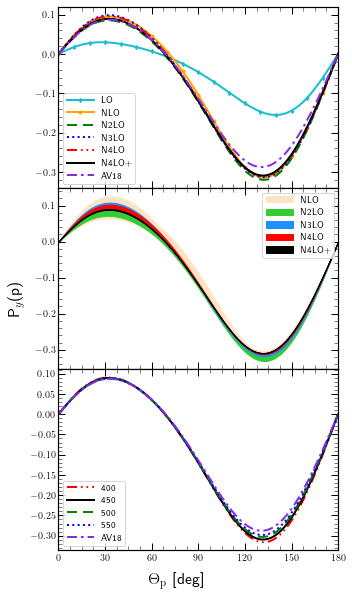

In [15]:
make_fig("POLNOUT2(y)", 100, 450, df_my, save=True, ylabel="P$_y$(p)")

In [79]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.Energy == 100) &
                    (df_my.WAVE == "SIEGERT")]

In [80]:
AMNMEV, s = df_tmp.groupby("angle")["POLNOUT2(y)"].agg(
    ["mean", "std"]).sort_values("std", ascending=False).iloc[0]
print(df_tmp.groupby("angle")["POLNOUT2(y)"].agg(
    ["mean", "std"]).sort_values("std", ascending=False).head())


          mean       std
angle                   
146.0 -0.27330  0.008735
145.0 -0.27770  0.008735
142.0 -0.28915  0.008730
143.0 -0.28565  0.008730
144.0 -0.28185  0.008730


In [17]:
def get_reldif_cutoff(df, observable, energy, angle):
    df_tmp = df[(df.FORCE == "N4LO+") &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
    reldif2 = df_tmp.pivot(index="angle", columns="CUTOFF")[observable].apply(lambda x: relative_diff(*x), axis=1)*100
    return reldif2.loc[angle]

In [21]:
get_reldif_cutoff(df_my, "POLNOUT2(y)", 30, 160)

/tmp/ipykernel_386620/3481350971.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs((max(args) - min(args))/np.mean(args))


4.0352661919294555

In [20]:
get_reldif_cutoff(df_my, "POLNOUT2(y)", 100, 130)

/tmp/ipykernel_386620/3481350971.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs((max(args) - min(args))/np.mean(args))


5.614951440463575

# Test

In [3]:
MN = 939.5653
MP = 938.2720
AMNMEV = 2.0*MP*MN/(MP+MN)
absb2 = 2.225
md = 2*AMNMEV-absb2


In [11]:
omegalab = np.arange(0,200,0.1)

In [12]:
OMEGACM = (-2*AMNMEV*md + np.sqrt(2.)*np.sqrt(-4*absb2*AMNMEV**2*md + 8*AMNMEV**3*md - 
            2*AMNMEV**2*md**2 + 4*AMNMEV**2*md*omegalab - AMNMEV*md*omegalab**2))/ (2.*AMNMEV)


In [19]:
Tlab = 2*(md - 2*AMNMEV + OMEGACM + OMEGACM**2/2/md)

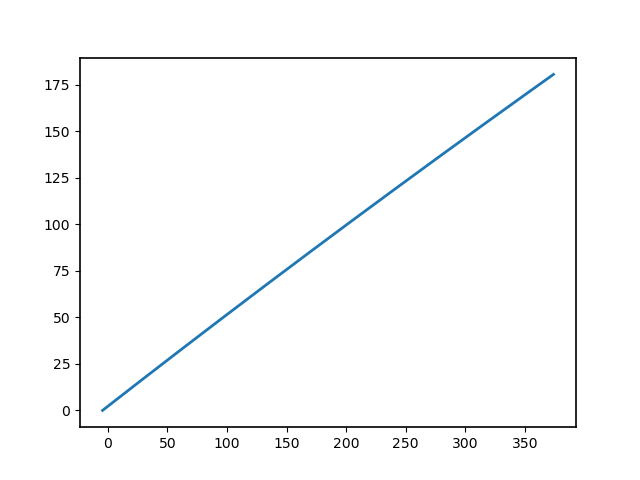

In [20]:
plt.figure()
plt.plot(Tlab, OMEGACM)
plt.show()

In [28]:
Tlab[950]

180.74393704617034

In [29]:
OMEGACM[950]

90.41758843966537